# Preprocessing/EDA for Small area income estimates for middle layer super output areas, England & Wales, 2011/12

Dataset link: https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/smallareaincomeestimatesformiddlelayersuperoutputareasenglandandwales

1.1 **Loading the dataset** from an .xlsx file to a Pandas DataFrame, then displaying the name of the sheets that have relevant information (i.e. variables/potential features)

In [1]:
import pandas as pd

# Loading the Excel file for MSOA Income Estimates from ONS
file_path = "../../data/raw/msoa_income.xlsx"

# Retrieving and displaying the sheet names
sheets = pd.ExcelFile(file_path).sheet_names
print("The sheet names/tables for MSOA Income Estimate data:", sheets)

The sheet names/tables for MSOA Income Estimate data: ['Contents', 'Metadata', 'Terms and Conditions', 'Total weekly income', 'Net weekly income', 'Net income before housing costs', 'Net income after housing costs', 'Related Publications']


1.2 **Defining the Sheets 4 to 7 as DataFrames.** The other sheets are irrelevant for the cleaning and analysis processes. Therefore for the **preprocessing stage**, these are the following steps:
- **Skipping the first three rows** to use the relevant column headers.
- **Removing the last row** because it is irrelevant to the values of interest and the context of the research.
- **Standardisation of column headers:** Convert to lowercase, replace the spaces with underscores, and remove the whitespace before and after the string. I'll be removing currency symbols from numerical values so that it does not interfere with the analysis.
- Checking for any **missing values**, though it is doubtful to be any.
- Checking for **duplicates** by using the first column as reference (MSOA Code should be unique for each row).
- 
- Fundamental **integrity checks** such as looking for negative numbers.

In [6]:
# Defining the relevant sheets now the names are known
relevant_sheets = ["Total weekly income", "Net weekly income", 
"Net income before housing costs", "Net income after housing costs"]

# Storing processed data by initialising a dictionary
adjust_data = {}

# Processing each relevant sheet
for sheet in relevant_sheets:
    print(f"Processing sheet: {sheet}")

    # Loading the relevant sheets and skipping the first three rows
    msoa_income_data = pd.read_excel(file_path, sheet_name = sheet, header = 4)

    # Removing the last row as it is irrelevant (i.e. not a numerical value or a category)
    msoa_income_data = msoa_income_data[:-1]

    # Standardising the column names 
    msoa_income_data.columns = (
        msoa_income_data.columns
        .str.strip() # Ensuring that the space before and after the strings do not affect analysis
        .str.lower() # Coverting the strings to lowercase
        .str.replace(" ", "_") # Replacing the spaces in between words with underscores
        .str.replace("£", "", regex = False) # Removing any currency symbols from numerical values
    )

    # Looking for any duplicates using the 'msoa_code' as this should be unique to each row
    duplicate_rows = msoa_income_data[msoa_income_data.duplicated(subset = ["msoa_code"])]
    if not duplicate_rows.empty:
        print(f"The duplicate rows found in {sheet}:")
        print(duplicate_rows)
        print("-" * 40)
    else:
        print("There are no duplicate rows in {sheet}.")
    
    # Checking for any missing values in the dataset
    print(f"The missing values in {sheet}:")
    print(msoa_income_data.isnull().sum())
    print("-" * 40)

    # Converting data types - income and limits to numeric data types
    # In other words, changing the values where its variable names contains the word 'limit' or 'income' in it.
    cols_numeric = [col for col in msoa_income_data.columns if "income" in col or "limit" in col]
    msoa_income_data[cols_numeric] = msoa_income_data[cols_numeric].apply(pd.to_numeric, errors = "coerce")

    # Identifying anomalies/outliers through some descriptive statisitics 
    print(f"These are the descriptive statistics for {sheet}:")
    print(msoa_income_data[cols_numeric].describe())
    print("-" * 40)

    # Some basic integrity checks such as negative or invalid values (the incomes should not be negative)
    income_invalid = msoa_income_data[cols_numeric].lt(0).any(axis = 1)
    if income_invalid.any():
        print(f"The invalid incomes values found in {sheet}:")
        print(msoa_income_data[income_invalid])
    else:
        print(f"No invalid income values in {sheet}")

    adjust_data[sheet] = msoa_income_data

Processing sheet: Total weekly income
There are no duplicate rows in {sheet}.
The missing values in Total weekly income:
msoa_code                    0
msoa_name                    0
local_authority_code         0
local_authority_name         0
region_code                  0
region_name                  0
total_weekly_income_()       0
upper_confidence_limit_()    0
lower_confidence_limit_()    0
confidence_interval_()       0
dtype: int64
----------------------------------------
These are the descriptive statistics for Total weekly income:
       total_weekly_income_()  upper_confidence_limit_()  \
count             7201.000000                7201.000000   
mean               731.353979                 801.719206   
std                190.048422                 208.079284   
min                300.000000                 340.000000   
25%                590.000000                 650.000000   
50%                710.000000                 770.000000   
75%                840.000000    

There are **no missing values or invalid income values**, which was expected. There are also **no duplicates** in terms of MSOA codes. 

1.4 I have to decide which sheet is more appropriate for analysis. In this dataset, we have confidence limits and incomes for the following categories, in order of the sheets shown above:
- Total Weekly Income 
- Net Weekly Income
- Net Income before Housing Costs
- Net Income after Housing Costs

Given the descriptive statistics for each dataset sheet **(specifically focusing on the incomes)**:
- Total Weekly Income is **significantly higher** in terms of **mean, std, 25%, 50%, 75%**, and **max** values.
- Net Weekly Income and Net Income before Housing Costs are **very close** in terms of **mean, 25%, 50%,** and **max** values.
- Net Weekly Income, Net Income before Housing Costs, and Net Income after Housing Costs are **very close** in terms of **std** values.
- Net Income after Housing Costs** is **significantly lower** in terms of **min** values
- Net Weekly Income, Net Income before Housing Costs, and Total Weekly Income are **very close** in terms of **min** values.

This means that:
- The higher values shown from the **Total Weekly Income** suggest that it is **undesirable** because it does not consider any deductions (i.e. taxes, housing costs). Therefore, it does not reflect the financial reality of households.
- **Net Weekly Income** and **Net Income before Housing Costs** do not include deductions for the housing costs, which is especially important if your income is at the lower end of the spectrum (see the research below). Also, their values are very similar, to the extent that having both of them would be somewhat redundant.
- The significantly lower minimum values of **Net Income after Income** suggest that housing costs may be very high for some people, and in terms of machine learning techniques, there is more variation regarding target variables. This is good because it can reduce the chances of overfitting. Therefore, this sheet is **more desirable** to use as it pertains to the financial reality of households.

#### Below is some research on the best category to choose:

According to this commentary on the following graph that investigates the relationship between income and life expectancy using MSOA  (https://www.health.org.uk/evidence-hub/money-and-resources/income/relationship-between-income-and-healthy-life-expectancy-by-neighbourhood):
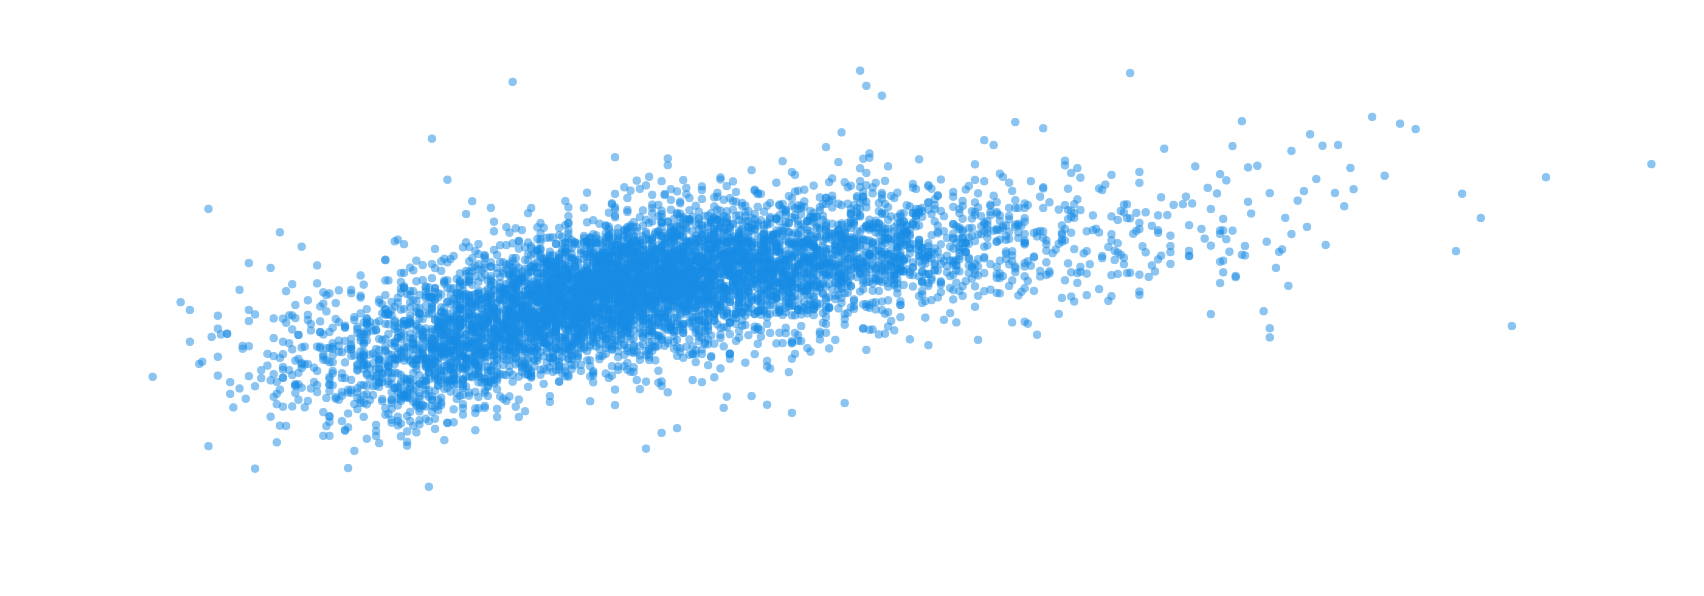
- Source: Health Foundation analysis of Office for National Statistics, Income Estimates for Small Areas, England & Wales, 2019/2020, Life expectancy at birth and age 65 by sex for Middle layer Super Output Areas (MSOAs), England: 2016 to 2020

They mention that the most accurate measurement to show the available resources would be the **Household Income after Housing Costs**. For example, those who are categorised within lower-income households would see a larger proportion of their income taken to pay for their domestic bills.  


#### Final Decision on MSOA Income Estimation data:
- The last sheet, **Household Income after Housing Costs** will be used for analysis
- The other sheets will be saved, in the scenario that the **generalisation** does not go well. This can be used for **sensitivity analysis**, "model stress tests** etc.

1.5 **Filter the dataset**, so that I am only focusing on values for the geographical area of London. Then do the steps mentioned above (i.e. Final Decision.....)

In [ ]:
# Separating the chosen sheet that will be used for analysis
chosen_sheet = "Net income after housing costs"
other_sheets = ["Total weekly income", "Net weekly income", 
"Net income before housing costs"]

# Saving the previously adjusted msoa_income_data to a .csv file
msoa_income_data.to_csv("../../data/processed/msoa_income.csv", index = False)

# Loading the sheets into separate variables
# One for the Net Income after Housing Costs
# And the variable will load the other sheets for backup (i.e. stress tests/sentiment analysis/ bad generalisation)
msoa_income_data = pd.read_csv("../../data/processed/msoa_income.csv", sheet_name = chosen_sheet, 
                               header = 4)
msoa_income_other = pd.read_csv("../../data/processed/msoa_income.csv", sheet_name = other_sheets,
                                header = 4)

